In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
from pickle import dump
from unicodedata import normalize
import tinysegmenter
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

C:\Users\NitishTalekar\Applictions\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')

    # read all text
    text = file.read()
    file.close()
    return text

def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

data = read_text("jpn.txt")
jpn_eng = to_lines(data)
jpn_eng = array(jpn_eng)
jpn_eng = jpn_eng[:10000,:]

jpn_eng

array([['Go.', '行け。'],
       ['Go.', '行きなさい。'],
       ['Hi.', 'こんにちは。'],
       ...,
       ['Tom kept his promise.', 'トムは約束を守った。'],
       ['Tom kicked Mary hard.', 'トムはメアリーを強く蹴った。'],
       ['Tom knocked him down.', 'トムは彼を殴り倒した。']], dtype='<U192')

In [3]:
jpn_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in jpn_eng[:,0]]
jpn_eng[:,0] = [jpn_eng[i,0].lower() for i in range(len(jpn_eng[:,0]))] 
jpn_eng

array([['go', '行け。'],
       ['go', '行きなさい。'],
       ['hi', 'こんにちは。'],
       ...,
       ['tom kept his promise', 'トムは約束を守った。'],
       ['tom kicked mary hard', 'トムはメアリーを強く蹴った。'],
       ['tom knocked him down', 'トムは彼を殴り倒した。']], dtype='<U192')

In [4]:
jpn_eng[:,1] = [" ".join(tinysegmenter.tokenize(i)[:-1]) for i in jpn_eng[:,1]]
jpn_eng

array([['go', '行け'],
       ['go', '行き なさい'],
       ['hi', 'こん にち は'],
       ...,
       ['tom kept his promise', 'トム は 約束 を 守っ た'],
       ['tom kicked mary hard', 'トム は メアリー を 強く 蹴っ た'],
       ['tom knocked him down', 'トム は 彼 を 殴り倒し た']], dtype='<U192')

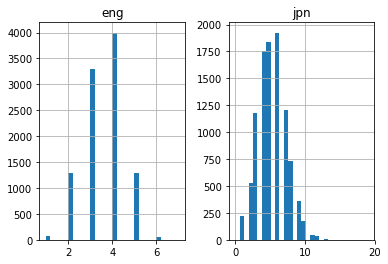

In [5]:
eng_l = []
jpn_l = []

# populate the lists with sentence lengths
for i in jpn_eng[:,0]:
      eng_l.append(len(i.split()))

for i in jpn_eng[:,1]:
      jpn_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'jpn':jpn_l})
# print(length_df)

length_df.hist(bins = 30)
plt.show()

In [29]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [31]:
eng_tokenizer = tokenization(jpn_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 4525


In [32]:
jpn_tokenizer = tokenization(jpn_eng[:, 1])
jpn_vocab_size = len(jpn_tokenizer.word_index) + 1

jpn_length = 8
print('Japanese Vocabulary Size: %d' % jpn_vocab_size)

Japanese Vocabulary Size: 8304


In [33]:
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [34]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(jpn_eng, test_size=0.2, random_state = 12)

In [35]:
# prepare training data
trainX = encode_sequences(jpn_tokenizer, jpn_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(jpn_tokenizer, jpn_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [36]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [38]:
model = define_model(jpn_vocab_size, eng_vocab_size, jpn_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [39]:
filename = 'jpn_model1.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=20, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Train on 12800 samples, validate on 3200 samples
Epoch 1/20
12800/12800 [==============================] - 184s 14ms/step - loss: 4.5515 - val_loss: 3.7610

Epoch 00001: val_loss improved from inf to 3.76103, saving model to jpn_model1.h5
Epoch 2/20
12800/12800 [==============================] - 167s 13ms/step - loss: 3.5251 - val_loss: 3.4448

Epoch 00002: val_loss improved from 3.76103 to 3.44484, saving model to jpn_model1.h5
Epoch 3/20
12800/12800 [==============================] - 164s 13ms/step - loss: 3.3886 - val_loss: 3.4220

Epoch 00003: val_loss improved from 3.44484 to 3.42203, saving model to jpn_model1.h5
Epoch 4/20
12800/12800 [==============================] - 154s 12ms/step - loss: 3.3185 - val_loss: 3.3728

Epoch 00004: val_loss improved from 3.42203 to 3.37281, saving model to jpn_model1.h5
Epoch 5/20
12800/12800 [==============================] - 651s 51ms/step - loss: 3.2696 - val_loss: 3.3602

Epoch 00005: val_loss improved from 3.37281 to 3.36024, saving model to

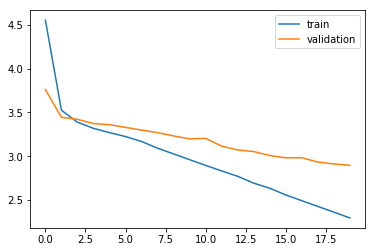

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [41]:
model = load_model('jpn_model1.h5')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [42]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [44]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [46]:
pred_df = pd.DataFrame({'jap':test[:,1],'actual' : test[:,0], 'predicted' : preds_text})

In [47]:
pred_df.sample(15)

,jap,actual,predicted
1877,私 なら できる,i can do it,do you to
3372,私 は 音楽 を 習っ て い ます,im learning music,i have a
50,この 家 は 売り物 で は あり ませ ん,this house isnt for sale,this is
2055,神 の みぞ が 知る,only god knows,this is
1111,医者 を 呼ん で 下さい,please call me a doctor,please me the
474,本当 に あり が とう,many thanks,its a
3304,彼 は 海 の 方 を 向い た,he faced toward the sea,he was his the
457,君 は 行か ない ほう が よい,youd better not go,i like to
857,何 が 欲しかっ た の,what did you want,what did you
2671,理 に 適っ てる と 思う,i think it makes sense,i have to a


In [ ]:
model = load_model('jpn_model1.h5')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))
    
pred_df = pd.DataFrame({'jap':test[:,1],'actual' : test[:,0], 'predicted' : preds_text})
pred_df.sample(15)

In [48]:
testX

array([[1417,    7,  104, ...,   18,    0,    0],
       [ 443,    1, 2925, ...,    3,   20,   17],
       [  20,  418,    1, ...,   37,   17,   14],
       ...,
       [3551, 3552,    7, ...,    3,   20,   17],
       [2353,    7,  273, ...,    0,    0,    0],
       [   8,    1, 2602, ...,    0,    0,    0]])